<a href="https://colab.research.google.com/github/dwgb93/TEI_WildfireSpread/blob/main/notebooks/Logistic_Regression_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Erd&#337;s Institute Fall Boot Camp - Team Mahogany

We're using data from [this paper](https://arxiv.org/pdf/2112.02447.pdf) to predict where wildfires spread based on 12 features including wind, temperature, humidity, vegetation, and elevation.

This is a first code demo from [Google Research](https://github.com/google-research/google-research/tree/master/simulation_research/next_day_wildfire_spread) to visualize the data.

Each .tfrecord file consists of 100 64km by 64km grids with 12 features, described below.

Licensed under the Apache License, Version 2.0
# Imports

Import the required libraries.

In [1]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
import numpy as np
import pandas as pd

Note: This links your Google Drive to Colab. Useful if the data is stored in Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Common functions

Run the following three cells to define the required library functions for loading the data.

In [3]:
# Constants for the data reader

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask']

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, std)
# I recalculated the statistics based on the s
DATA_STATS = {
    # 0.1 percentile, 99.9 percentile
    # Elevation
    'elevation' : (0.0, 3536.0, 896.5714, 842.6101),
    # Drought index - this claimed to be pressure, but it's Palmer Drought Severity Index
    # https://en.wikipedia.org/wiki/Palmer_drought_index
    # 0.1 percentile, 99.9 percentile
    'pdsi' : (-6.0559, 6.7432, -0.7729, 2.4407),
    # Normalized Difference Vegetation Index https://gisgeography.com/ndvi-normalized-difference-vegetation-index/
    'NDVI' : (-3826.0, 9282.0, 5350.6865, 2185.2192),
    # Precipitation in mm.
    # Negative values make no sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 19.2422, 0.3234289, 1.5336641),
    # Specific humidity ranges from 0 to 100%.
    'sph': (0., 1., 0.0065263123, 0.003735537), #max changed to 1
    # Wind direction - degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th' : (0.0, 360.0, 146.6468, 3435.0725),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn' : (253.15, 299.6313, 281.85196, 18.4972), #min changed
    # -20 degree C, 99.9 percentile
    'tmmx' : (253.15, 317.3869, 297.71643, 19.4581), #min changed
    # Wind speed.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs' : (0.0, 9.7368, 3.6278, 1.3092),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc' : (0.0, 109.9254, 53.4690, 25.0980),
    # Population
    # min, 99.9 percentile
    'population' : (0.0, 2935.7548828125, 30.4603, 214.20015),
    # We don't want to normalize the FireMasks.
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [4]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
    num_in_channels: Number of channels in `input_img`.
    num_out_channels: Number of channels in `output_img`.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Calls `tf.image.central_crop` on input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

In [5]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]
  
  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [57]:
def get_metrics(precs, recs):
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))
  return precs[np.argmax(f1s)], recs[np.argmax(f1s)]

Define the features in the dataset

In [6]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

# Load the dataset.

Enter the file pattern of the dataset.

In [7]:
file_pattern = '/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Final Project - Mahogany/Data/next_day_wildfire_spread_train*'
#Location within MY GDrive. Might not be the same for you. I don't know if you can link to my drive this way...
val_file_pattern = '/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Final Project - Mahogany/Data/next_day_wildfire_spread_eval*'

test_file_pattern = '/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Final Project - Mahogany/Data/next_day_wildfire_spread_test*'

Get the training, validation, and testing datasets

In [8]:
dataset = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=14979,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

valset = get_dataset(
      val_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=1877,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=True)

testset = get_dataset(
      test_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=1877,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=True)

TF Datasets are loaded lazily, so materialize the first batch of inputs (11 environmental features) and labels (fire mask).

In [9]:
inputs, labels = next(iter(dataset))

inputs_val, labels_val = next(iter(valset))

inputs_test, labels_test = next(iter(testset))

Find how much fire is in each file. They should add to be 18,545 which is the total number of fires.

In [10]:
inputs.shape

TensorShape([14979, 32, 32, 12])

In [11]:
inputs_val.shape

TensorShape([1877, 32, 32, 12])

In [12]:
inputs_test.shape

TensorShape([1689, 32, 32, 12])

# Logistic Regression Model


Import the model we will be using

In [13]:
## import LogisticRegression
from sklearn.linear_model import LogisticRegression

Reshape the data in the next two cells to remove "no data" files

In [31]:
X_train = tf.reshape(inputs, [-1,12]).numpy() #len(inputs)*32*32,12
y_train = tf.reshape(labels, [-1]).numpy() #len(labels)*32*32

X_val = tf.reshape(inputs_val, [-1,12]).numpy() 
y_val = tf.reshape(labels_val, [-1]).numpy() 

X_test = tf.reshape(inputs_test, [-1,12]).numpy() 
y_test = tf.reshape(labels_test, [-1]).numpy() 

In [15]:
#Don't bother learning where no-data is during training.
#makes training quicker and binary (thank fuck)
X = X_train[np.where(y_train >= 0)]
y = y_train[np.where(y_train >= 0)]

set up Logistic Regression model

In [16]:
log_reg = LogisticRegression(penalty = 'none')


log_reg.fit(X,y)

LogisticRegression(penalty='none')

Create a pandas dataframe to find the important features of this model

In [17]:
score_df = pd.DataFrame({'feature':TITLES[:-1],
                            'importance_score': np.abs(log_reg.coef_[-1]),
                            'actual_value': log_reg.coef_[-1]})

score_df.sort_values('importance_score',ascending=False)

,feature,importance_score,actual_value
11,Previous\nfire\nmask,3.055462,3.055462
1,Wind\ndirection,2.939174,2.939174
3,Min\ntemp,0.975030,0.975030
9,Population\ndensity,0.361442,-0.361442
10,Energy\nrelease\ncomponent,0.322639,0.322639
4,Max\ntemp,0.292365,-0.292365
0,Elevation,0.181095,0.181095
6,Precip,0.162624,-0.162624
7,Drought,0.135867,-0.135867
2,Wind\nvelocity,0.069142,0.069142


# Metrics: Precision, Recall, F1, AUC (PR)

Import the confusion matrix so we can get the actual fires and predicted fires

In [19]:
## now we can import the confusion matrix
from sklearn.metrics import confusion_matrix

Remove "no fire" data in the validation/test data (uncomment one or the other)

In [73]:
#Leave these commented if you want the training accuracy
#Uncomment one or the other if you want the val/test data
# X, y = X_val, y_val
X, y = X_test, y_test


#Don't bother learning where no-data is during training.
#makes training quicker and binary (thank fuck)
X = X[np.where(y >= 0)]
y = y[np.where(y >= 0)]

The probability of there being fire

In [74]:
#We just want the probability of being fire
y_pred = log_reg.predict_proba(X)[:,-1]

Get the actual fire and predicted fire values in the validation/test data 

In [68]:
## just like mse, actual then prediction
cum = confusion_matrix(y, np.round(y_pred))#, sample_weight = mask)
cum

array([[14599832,    15884],
       [  368524,    10974]])

Get the True Negative (TN), False Positive (FP), False Negative (FN), and True Positive (TP)

In [69]:
## Calculate the confusion matrix here

TN = cum[0,0] #these are nomally 0's and ones
FP = cum[0,1] #+ cum[0,2] # acounting for incorrectly predicting [-1] # no longer need to do these -> taken care of above
FN = cum[1,0] #+ cum[2,0] # accounting for incorrectly predicitng [-1]
TP = cum[1,1]

Get the baseline precision and recall

In [70]:
## calculate recall and precision here
print("The baseline precision is", 
         np.round(TP/(FP + TP), 4))

print("The baseline recall is", 
         np.round(TP/(FN + TP), 4))



The baseline precision is 0.4086
The baseline recall is 0.0289


Find the best precision and recall values in the next two cells

In [71]:
cutoffs = np.arange(0.001,.975,.001)
precs = []
recs = []
y = y.astype(int)
#y =(y*mask).numpy().astype(int)

for cutoff in cutoffs:
    TP = (1*(y_pred >= cutoff) & y).sum()
    PP = 1*(y_pred >= cutoff).sum() #predicted positives = # Denominator for precision
    AP = y.sum() #Actual positives # Denominator for recall
    precs.append(TP/PP)
    recs.append(TP/AP)

<ipython-input-71-842af3e8b94b>:11: RuntimeWarning: invalid value encountered in long_scalars
  precs.append(TP/PP)


In [72]:
prec, rec = get_metrics(precs, recs)

auc = tf.keras.metrics.AUC(curve = 'PR')
auc.update_state(y, y_pred)

print("The best precision is", prec)
print("The best recall is", rec)
print("The auc is", auc.result().numpy())

<ipython-input-57-37b4cf7522e5>:2: RuntimeWarning: invalid value encountered in true_divide
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))


The best precision is 0.39170342488580445
The best recall is 0.26324776415158974
The auc is 0.16516939


# Plots of Precision/recall curves


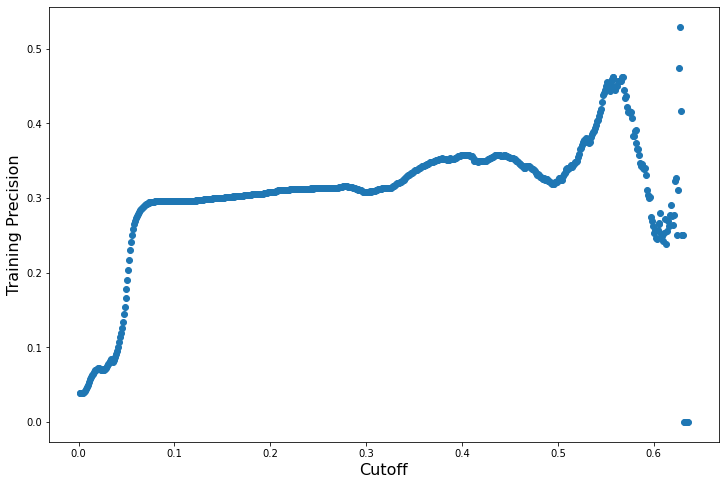

In [50]:
plt.figure(figsize=(12,8))

plt.scatter(cutoffs,precs)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("Training Precision",fontsize=16)

plt.show()

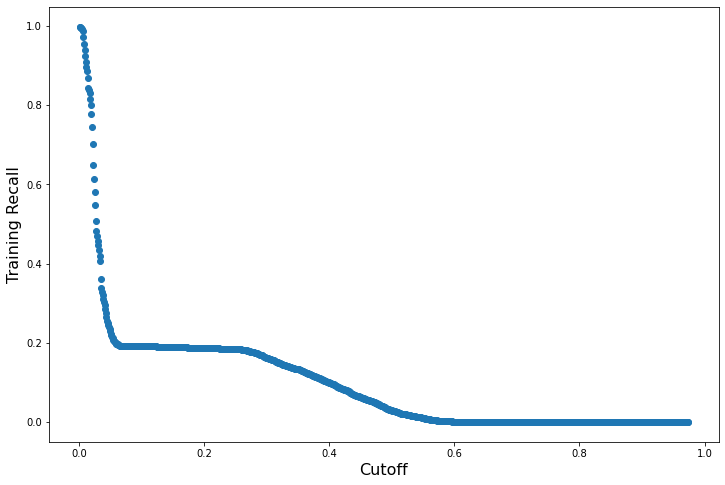

In [51]:
plt.figure(figsize=(12,8))

plt.scatter(cutoffs,recs)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("Training Recall",fontsize=16)

plt.show()

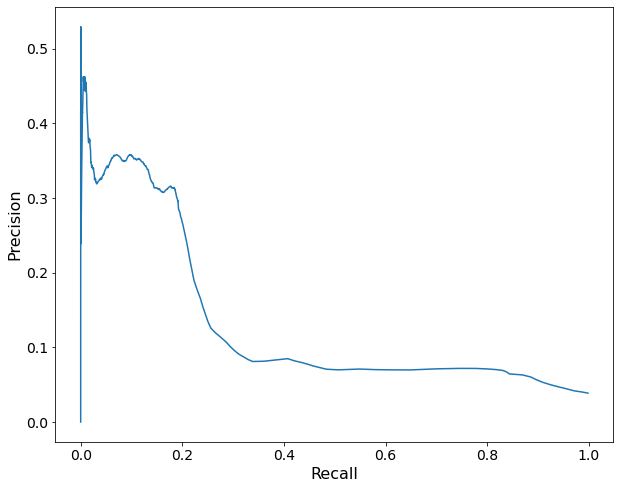

In [52]:
plt.figure(figsize=(10,8))

plt.plot(recs, precs)

plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

<ipython-input-53-6bd9b1a1fe46>:3: RuntimeWarning: invalid value encountered in true_divide
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))


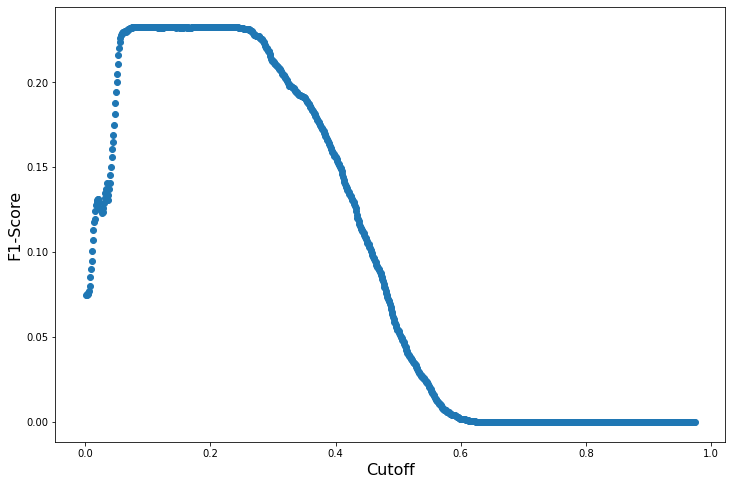

In [53]:
plt.figure(figsize=(12,8))

f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))
plt.scatter(cutoffs,f1s)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("F1-Score",fontsize=16)

plt.show()

try l1 or l2 penalty - see if that changes prec/recall

calculate coefficients for each feature - what is most important?

remove each feature one at a time - what affects precision most?

Try convolution to create a new feature that includes spatial data (see Kaggle)


# Plotting function

Plot the predicted fire 

In [76]:
n_rows = 10
n_features = inputs.shape[3]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = INPUT_FEATURES

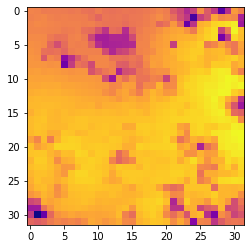

In [81]:
y_pred = log_reg.predict_proba(X_test)[:,-1]
pred = np.reshape(y_pred, (len(inputs_test),32,32))
plt.imshow(pred[0], cmap='plasma') 

Plot the Last fire, Actual fire, and Predicted fire for comparison to see how well this model did in predicting fire

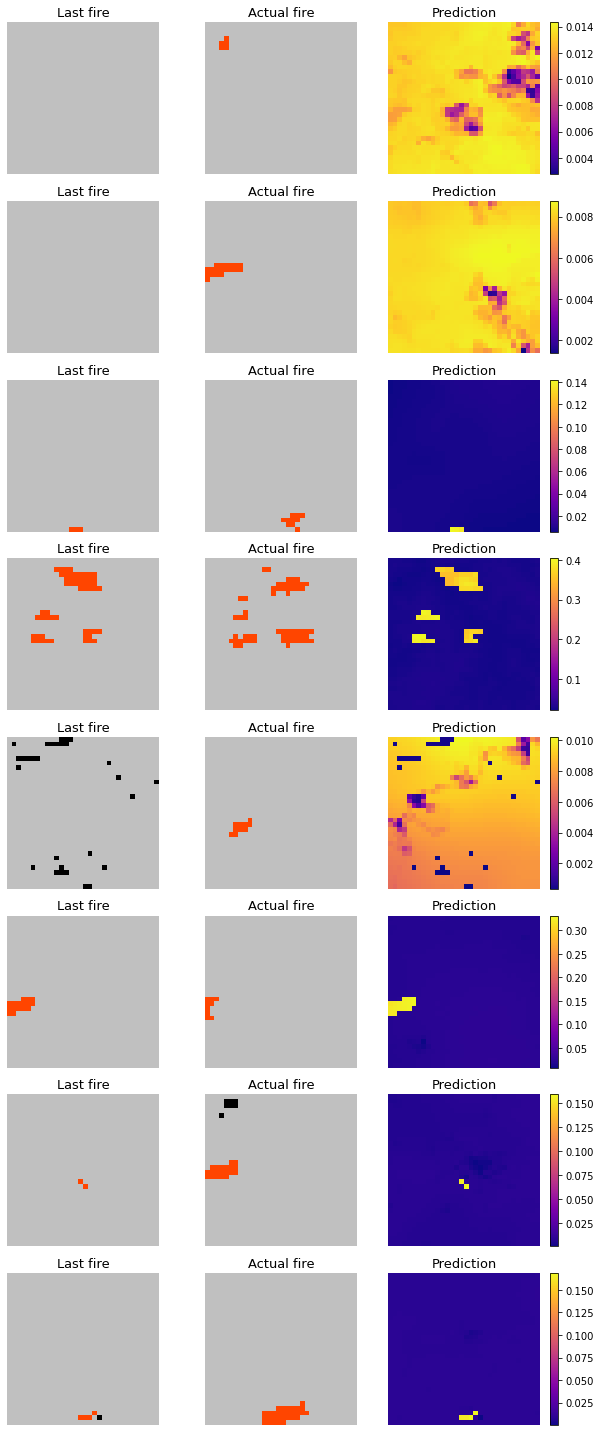

In [91]:
fig = plt.figure(figsize=(9,20))
n_rows = 8

for i in range(n_rows):
  fire_index = i +1000
  plt.subplot(n_rows,3, 3*i + 1)
  plt.title("Last fire", fontsize=13)
  plt.imshow(inputs_test[fire_index, :, :, -1], cmap=CMAP, norm=NORM)
  plt.axis('off')
  plt.subplot(n_rows,3, 3*i + 2)
  plt.title("Actual fire", fontsize=13)
  plt.imshow(labels_test[fire_index, :, :, 0], cmap=CMAP, norm=NORM)
  plt.axis('off')
  plt.subplot(n_rows,3, 3*i + 3)
  plt.title("Prediction", fontsize=13)
  plt.imshow(pred[fire_index], cmap='plasma') 
  plt.colorbar()
  plt.axis('off')
plt.tight_layout()